# Calculate and glacier terminus positions at different dates
### Jukes Liu

Files used:
    - Terminus box left midpoints and centerlines (Boxes_coords_pathrows.csv)
    - Terminus chains picked by size (terminuspicks_size_2019_07_24.csv)
    - Terminus chains picked by mass (terminuspicks_mass_2019_07_24.csv)
    - DateTimes of satellite images (datetags.csv)

### Set up: Import packages, read in csv files

In [514]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.image as mpimg
import datetime
import types
import os
import cv2

basepath = '/home/jukes/Documents/Sample_glaciers/'

#set date for the terminus picks analyzed
d8 = '2019_10_02'

In [515]:
#Read in file with box coordinates
box_df = pd.read_csv(basepath+'Boxes_coords_pathrows.csv', sep=',', dtype=str)
box_df = box_df.set_index('BoxID')

#Read in files with terminus picks and drop those that have NaNs (no terminus line picked)
#size
termini_df_s = pd.read_csv(basepath+'terminuspicks_size_'+d8+'.csv', sep=',', dtype=str, usecols=[0,1,2,3,4], header=1)
termini_df_s = termini_df_s.dropna()
#mass
termini_df_m = pd.read_csv(basepath+'terminuspicks_mass_'+d8+'.csv', sep=',', dtype=str, usecols=[0,1,2,3,4], header=1)
termini_df_m = termini_df_m.dropna()

#Check number of rows for the termini_dfs:
print(termini_df_m.shape[0])

#look at the DataFrames
# box_df
termini_df_m.head(10)

3263


BoxID                  Scene Scale             Mass Order
1    001  LC80310052014242LGN00   000  1837.3024148393     4
2    001  LC80310052014242LGN00   002  3126.3611437028     3
3    001  LC80310052014242LGN00   003  3213.5711912179     2
4    001  LC80310052014242LGN00   020  3285.9529039998     1
5    001  LC80310052016152LGN00   026  2485.4565421714     1
6    001  LC80310052014226LGN00   000  2920.6270045333     3
7    001  LC80310052014226LGN00   002  2991.4421030595     2
8    001  LC80310052014226LGN00   003  3667.9432926433     1
9    001  LC80340052016109LGN00   000  3249.4745146466     2
10   001  LC80340052016109LGN00   001  3261.8441709793     1

### Calculate terminus position using centerline intersection with each of the dat files

Grab centerline slopes and intercepts from box_df:

In [516]:
#FOR EACH BOX GRAB SLOPE AND INTERCEPT AS DICTIONARY WITH BOXID
slopes = {}
intercepts = {}

for index, row in box_df.iterrows():
#     if index == '004':
        #Grab centerline slope and intercept from the box_df
        slope = np.float(row['cline_slope'])
        intercept = np.float(row['cline_intercept'])
        slopes.update( {index: slope})
        intercepts.update( {index: intercept})
#         print(slope, intercept)

For each terminus line entry in termini_df_m or s, read in the .dat file and find the intersection point with the centerline (if there is an intersection at all):

In [517]:
#mass or size:
massorsize = 'mass'
counter = 0

#hold intserection x and y coordinates and the index
indices = []
intersect_x = []
intersect_y = []

#Read in the dat files using BoxID, scene, and scale names:
for idx, rw in termini_df_m.iterrows():
            BoxID = rw['BoxID']
            scene_name = rw['Scene']
            scale = rw['Scale']
            slope = np.float(slopes[BoxID])
            intercept = np.float(intercepts[BoxID])
            
            #grab each dat file corresponding to each terminus line entry
            datpath_base = '/media/jukes/jukes1/LS8aws/Box'+BoxID+"/rotated/resized/"
            datpath = datpath_base+"crop_R_"+scene_name+"_B8_PS_Buffer"+BoxID+".pgm_max_gaussian/terminus_highest"+massorsize+"/"
            final_dat_trim = datpath+"terminus_trim_"+scale+".dat"
            final_dat = datpath+"terminus_"+scale+".dat"
            
            #Read in dat file as np array and grab x and y values
            term_trim_dat = np.loadtxt(final_dat_trim)
            
            #Flag to stop the search when one centerline intersection is found            
            intersectfound = False
            
            #grab x and y values for the terminus line from the dat files
            for j in term_trim_dat:
                x, y = (int(j[0]), int(j[1]))
                
                #FOR EACH X VALUE IN THE DAT VALUE, CALCULATE THE CORRESPONDING CENTERLINE Y
                cline_y = int(slope*x + intercept)
                
                #IF THE Y-VALUE for the line correponds to this calculated centerline Y, this is the intersection point
                if intersectfound == False and cline_y == y:
                    print(idx, BoxID, scene_name, scale, x, y)
                    intersectfound = True
                    counter = counter+1
                    indices.append(idx)
                    intersect_x.append(x)
                    intersect_y.append(y)

1 001 LC80310052014242LGN00 000 143 161
2 001 LC80310052014242LGN00 002 143 161
3 001 LC80310052014242LGN00 003 143 161
4 001 LC80310052014242LGN00 020 141 161
5 001 LC80310052016152LGN00 026 140 161
6 001 LC80310052014226LGN00 000 143 161
7 001 LC80310052014226LGN00 002 143 161
8 001 LC80310052014226LGN00 003 143 161
9 001 LC80340052016109LGN00 000 146 161
10 001 LC80340052016109LGN00 001 146 161
13 001 LC80360042015120LGN00 003 147 160
14 001 LC80360042015120LGN00 004 147 160
15 001 LC80310052015149LGN00 008 163 159
16 001 LC80310052015149LGN00 009 162 159
17 001 LC80310052015149LGN00 010 162 159
18 001 LC80310052015149LGN00 012 162 159
19 001 LC80310052015149LGN00 030 163 159
20 001 LC80360042016091LGN00 000 147 160
21 001 LC80360042016091LGN00 001 147 160
22 001 LC80310052014082LGN00 000 154 160
23 001 LC80310052014082LGN00 001 154 160
24 001 LC80310052014082LGN00 002 154 160
25 001 LC80310052014082LGN00 004 154 160
26 001 LC80310052014082LGN00 005 154 160
27 001 LC80360042015168LG

300 001 LC80350052015113LGN00 000 147 160
301 001 LC80350052015113LGN00 001 147 160
302 001 LC80350052015113LGN00 002 147 160
303 001 LC80350052015113LGN00 005 148 160
304 001 LC80350052015113LGN00 006 148 160
305 001 LC80340052015218LGN00 006 161 159
306 001 LC80340052015218LGN00 012 162 159
307 001 LC80340052015218LGN00 013 162 159
308 001 LC80340052017079LGN00 000 150 160
309 001 LC80340052017079LGN00 011 149 160
310 001 LC80340052014103LGN00 000 148 160
311 001 LC80340052014103LGN00 002 148 160
312 001 LC80340052014103LGN00 003 148 160
313 001 LC80330052013253LGN00 020 138 162
314 001 LC80330052013253LGN00 021 138 162
315 001 LC80330052013253LGN00 022 138 162
316 001 LC80330052013253LGN00 024 137 162
317 001 LC80310052015213LGN00 003 140 161
318 001 LC80310052015213LGN00 004 140 161
319 001 LC80310052015213LGN00 008 140 161
320 001 LC80310052015213LGN00 010 140 161
321 001 LC80310052016072LGN00 020 156 159
322 001 LC80310052016072LGN00 030 154 160
323 001 LC80330052014160LGN00 010 

604 002 LC80310052014194LGN00 049 639 581
606 002 LC80310052015133LGN00 042 671 582
607 002 LC80310052014242LGN00 045 650 581
608 002 LC80310052014242LGN00 046 649 581
609 002 LC80310052014242LGN00 047 649 581
610 002 LC80310052014242LGN00 048 648 581
611 002 LC80310052014242LGN00 049 647 581
612 002 LC80310052015245LGN00 018 663 582
613 002 LC80310052015245LGN00 027 661 581
614 002 LC80310052015245LGN00 028 661 581
615 002 LC80310052015245LGN00 029 660 581
616 002 LC80310052015245LGN00 036 658 581
617 002 LC80300052016273LGN00 019 660 581
618 002 LC80300052016273LGN00 020 660 581
619 002 LC80300052016273LGN00 024 659 581
620 002 LC80300052016273LGN00 025 659 581
621 002 LC80300052016273LGN00 026 659 581
627 002 LC80300052014251LGN00 015 664 582
628 002 LC80300052014251LGN00 043 652 581
629 002 LC80300052014251LGN00 045 651 581
630 002 LC80300052014251LGN00 046 650 581
631 002 LC80300052014251LGN00 047 650 581
635 002 LC80310052016120LGN00 036 603 580
636 002 LC80310052014258LGN00 000 

1027 120 LC82320172014114LGN00 027 132 149
1028 120 LC82330172016303LGN00 009 146 150
1029 120 LC82330172016303LGN00 013 146 150
1030 120 LC82330172016303LGN00 014 128 149
1031 120 LC82330172016303LGN00 016 128 149
1032 120 LC82330172016303LGN00 018 128 149
1033 120 LC82320182014018LGN00 003 148 150
1034 120 LC82320182014018LGN00 004 148 150
1035 120 LC82320182014018LGN00 005 148 150
1036 120 LC82320182014018LGN00 037 146 150
1037 120 LC82320182014018LGN00 038 146 150
1038 120 LC82320172014306LGN00 013 135 149
1039 120 LC82320172014306LGN00 014 135 149
1040 120 LC82320172014306LGN00 015 135 149
1041 120 LC82320172014306LGN00 017 135 149
1042 120 LC82320172014306LGN00 018 134 149
1043 120 LC82330172013102LGN01 001 151 150
1044 120 LC82330172013102LGN01 002 151 150
1045 120 LC82330172013102LGN01 009 151 150
1046 120 LC82330172013102LGN01 012 150 150
1047 120 LC82330172013102LGN01 039 141 150
1048 120 LC82320172014274LGN00 016 171 151
1049 120 LC82320172014274LGN00 018 170 151
1050 120 LC

1287 120 LC82320172014130LGN00 005 151 150
1288 120 LC82320172014130LGN00 006 151 150
1289 120 LC82320172014066LGN00 000 151 150
1290 120 LC82320172014066LGN00 003 151 150
1291 120 LC82320172014066LGN00 004 151 150
1292 120 LC82320172014066LGN00 005 151 150
1293 120 LC82320182015213LGN00 007 152 150
1294 120 LC82320182015213LGN00 008 152 150
1295 120 LC82320182015213LGN00 012 152 150
1296 120 LC82320182015213LGN00 015 152 150
1297 120 LC82320182015213LGN00 016 152 150
1298 120 LC82330172015172LGN00 006 135 149
1299 120 LC82330172015172LGN00 010 135 149
1300 120 LC82330172015172LGN00 016 135 149
1301 120 LC82330172015172LGN00 022 152 150
1302 120 LC82330172015172LGN00 031 152 150
1303 120 LC82320172014162LGN00 032 152 150
1304 120 LC82320172014162LGN00 033 151 150
1305 120 LC82320172014162LGN00 034 151 150
1306 120 LC82320172014162LGN00 038 148 150
1307 120 LC82320172014162LGN00 042 141 150
1308 120 LC82320172016056LGN00 003 151 150
1309 120 LC82320172016056LGN00 005 151 150
1310 120 LC

1541 174 LC82320172015021LGN00 030 279 338
1542 174 LC82320172015021LGN00 034 277 339
1543 174 LC82320172015021LGN00 035 277 339
1544 174 LC82320172015021LGN00 037 277 339
1545 174 LC82320172015021LGN00 042 273 340
1546 174 LC82320172016328LGN00 000 290 334
1547 174 LC82320172015197LGN00 000 307 329
1548 174 LC82320172015197LGN00 001 307 329
1549 174 LC82320172015197LGN00 008 307 329
1550 174 LC82320172015197LGN00 009 307 329
1551 174 LC82320172014114LGN00 033 349 315
1552 174 LC82320172014114LGN00 039 357 313
1553 174 LC82320172014114LGN00 042 359 312
1554 174 LC82320172016024LGN00 022 269 341
1555 174 LC82320172016024LGN00 025 268 342
1556 174 LC82320172016024LGN00 034 325 323
1557 174 LC82320172016024LGN00 045 291 334
1558 174 LC82320172016024LGN00 047 289 335
1559 174 LC82320172016264LGN00 004 297 332
1560 174 LC82320172016264LGN00 005 297 332
1561 174 LC82320172016264LGN00 008 297 332
1562 174 LC82320172016264LGN00 009 297 332
1567 174 LC82320172015069LGN00 026 320 325
1568 174 LC

1812 235 LC82320152014306LGN00 021 237 214
1813 235 LC82320152016264LGN00 006 212 208
1826 235 LC82320152016216LGN00 009 185 202
1827 235 LC82320152016216LGN00 019 202 206
1828 235 LC82330152013246LGN00 012 240 215
1829 235 LC82330152013246LGN00 014 240 215
1830 235 LC82330152013246LGN00 022 241 215
1833 235 LC82320152016056LGN00 015 201 206
1834 235 LC82320152016056LGN00 018 201 206
1835 235 LC82320152016056LGN00 035 215 209
1839 235 LC82330152015140LGN00 024 235 213
1840 235 LC82330152015140LGN00 032 238 214
1841 235 LC82330152015140LGN00 033 238 214
1842 235 LC82330152015140LGN00 038 243 215
1843 235 LC80010152016166LGN00 011 235 213
1844 235 LC80010152016166LGN00 028 237 214
1846 235 LC80010152014208LGN00 017 281 224
1847 235 LC80010152014208LGN00 018 281 224
1848 235 LC80010152014208LGN00 020 281 224
1849 235 LC80010152014208LGN00 022 281 224
1850 235 LC82320152015133LGN00 023 198 205
1851 235 LC82320152015133LGN00 027 199 205
1852 235 LC82320152015133LGN00 028 199 205
1853 235 LC

2095 259 LC82330152016287LGN00 040 429 499
2096 259 LC82330152016287LGN00 041 428 499
2097 259 LC82330152016287LGN00 042 428 499
2098 259 LC82330152016207LGN00 041 283 488
2099 259 LC80010152013109LGN01 031 307 490
2100 259 LC80010152013109LGN01 032 308 490
2101 259 LC80010152013109LGN01 038 312 490
2102 259 LC80010152013109LGN01 040 311 490
2103 259 LC80010152013109LGN01 041 310 490
2105 259 LC82330152014025LGN00 042 290 489
2106 259 LC82330152014025LGN00 043 288 489
2107 259 LC82330152014025LGN00 044 286 489
2110 259 LC82320152014178LGN00 021 284 488
2111 259 LC82320152014178LGN00 041 275 488
2113 259 LC80010152014240LGN00 035 550 507
2114 259 LC80010152014240LGN00 037 549 507
2115 259 LC80010152014240LGN00 039 549 507
2116 259 LC80010152014240LGN00 041 549 507
2117 259 LC80010152014240LGN00 047 549 507
2118 259 LC82320152015101LGN00 008 285 488
2120 259 LC82320152015101LGN00 011 278 488
2121 259 LC82320152015101LGN00 012 286 489
2122 259 LC82320152015101LGN00 016 286 489
2123 259 LC

2549 531 LC80070022016272LGN00 038 236 239
2550 531 LC80070022016272LGN00 039 236 239
2551 531 LC80070022016272LGN00 040 236 239
2552 531 LC80070022016272LGN00 047 235 239
2553 531 LC80070022016272LGN00 048 235 239
2554 531 LC80090022016222LGN00 013 238 239
2555 531 LC80090022016222LGN00 014 238 239
2556 531 LC80090022016222LGN00 015 238 239
2557 531 LC80090022016222LGN00 018 238 239
2558 531 LC80060032016121LGN00 002 238 239
2559 531 LC80060032016121LGN00 003 238 239
2560 531 LC80140012016129LGN00 009 243 238
2561 531 LC80140012016129LGN00 010 243 238
2562 531 LC80140012016129LGN00 013 244 238
2563 531 LC80140012016129LGN00 019 172 249
2564 531 LC80140012016129LGN00 033 246 237
2565 531 LC80080022016167LGN00 005 237 239
2566 531 LC80120022016179LGN00 000 178 248
2567 531 LC80100022016085LGN00 000 239 239
2568 531 LC80090022015123LGN00 002 174 249
2569 531 LC80090022015123LGN00 003 213 243
2570 531 LC80090022014216LGN00 014 274 233
2571 531 LC80090022014216LGN00 037 230 240
2572 531 LC

2789 531 LC80160012016111LGN00 003 233 240
2790 531 LC80160012016111LGN00 004 233 240
2792 531 LC80140012015126LGN00 045 288 231
2793 531 LC80140012015126LGN00 046 286 231
2794 531 LC80100022013236LGN00 000 240 238
2795 531 LC80100022013236LGN00 005 240 238
2796 531 LC80100022013236LGN00 032 237 239
2797 531 LC80100022013236LGN00 033 237 239
2798 531 LC80110022014166LGN00 019 233 240
2800 531 LC80150012014226LGN00 035 234 239
2801 531 LC80150012014226LGN00 041 240 238
2802 531 LC80150012014226LGN00 043 243 238
2803 531 LC80150012014226LGN00 045 247 237
2804 531 LC80150012014226LGN00 047 250 237
2805 531 LC80080022014257LGN00 000 237 239
2806 531 LC80080022014257LGN00 001 211 243
2807 531 LC80080022014257LGN00 016 205 244
2808 531 LC80140012017099LGN00 000 242 238
2809 531 LC80140012017099LGN00 001 242 238
2810 531 LC80140012017099LGN00 012 175 249
2811 531 LC80140012017099LGN00 018 173 249
2812 531 LC80140012017099LGN00 035 243 238
2813 531 LC80120022013266LGN00 045 277 233
2814 531 LC

3028 531 LC80110022016236LGN00 048 257 236
3029 531 LC80120022016163LGN00 000 177 248
3030 531 LC80120022016163LGN00 003 177 248
3031 531 LC80140012014123LGN00 012 244 238
3032 531 LC80140012014123LGN00 015 244 238
3033 531 LC80140012014123LGN00 019 172 249
3034 531 LC80140012014123LGN00 033 242 238
3035 531 LC80140012014123LGN00 035 242 238
3036 531 LC80110022016204LGN00 018 237 239
3037 531 LC80110022016204LGN00 020 236 239
3038 531 LC80110022016204LGN00 049 232 240
3039 531 LC80090022013261LGN00 042 237 239
3040 531 LC80090022013261LGN00 045 249 237
3041 531 LC80090022013261LGN00 047 257 236
3042 531 LC80090022013261LGN00 048 259 235
3043 531 LC80090022013261LGN00 049 260 235
3044 531 LC80080022016103LGN00 001 238 239
3045 531 LC80080022016103LGN00 005 239 239
3046 531 LC80080022016103LGN00 009 172 249
3047 531 LC80080022016103LGN00 015 240 238
3049 531 LC80100022014143LGN00 003 242 238
3050 531 LC80100022014143LGN00 005 242 238
3051 531 LC80100022014143LGN00 010 243 238
3052 531 LC

3271 531 LC80060032014211LGN00 038 227 240
3272 531 LC80070032015269LGN00 003 175 249
3273 531 LC80070032015269LGN00 004 234 239
3274 531 LC80070032015269LGN00 014 173 249
3275 531 LC80070032015269LGN00 015 186 247
3277 531 LC80140012015158LGN00 023 242 238
3278 531 LC80140012015158LGN00 025 243 238
3279 531 LC80070032016208LGN00 016 238 239
3280 531 LC80070032016208LGN00 017 238 239
3281 531 LC80070032016208LGN00 018 237 239
3282 531 LC80070032016208LGN00 036 236 239
3283 531 LC80160012014233LGN00 036 236 239
3284 531 LC80130022014100LGN00 002 238 239
3285 531 LC80130022014100LGN00 022 172 249
3286 531 LC80130022014100LGN00 037 246 237
3288 531 LC80130022014180LGN00 011 242 238
3289 531 LC80130022014180LGN00 023 242 238
3290 531 LC80150012016232LGN00 029 237 239
3291 531 LC80140012013232LGN00 003 241 238
3292 531 LC80140012013232LGN00 004 241 238
3293 531 LC80140012013232LGN00 005 241 238
3294 531 LC80070022016160LGN00 000 241 238
3295 531 LC80070022016160LGN00 003 217 242
3296 531 LC

Add these intersection points back into the data frame by index:

In [518]:
intersections_df = pd.DataFrame(list(zip(indices, intersect_x, intersect_y)),
              columns=['index','Intersect_x','Intersect_y'])
intersections_df = intersections_df.set_index('index')
intersections_df.head(11)

Intersect_x  Intersect_y
index                          
1              143          161
2              143          161
3              143          161
4              141          161
5              140          161
6              143          161
7              143          161
8              143          161
9              146          161
10             146          161
13             147          160

In [519]:
#For mass
termini_df_m.index.name='index'
new_df = termini_df_m.merge(intersections_df, how= 'outer', on='index')

In [523]:
print(new_df.shape)
new_df.head(15)

(3263, 7)


BoxID                  Scene Scale             Mass Order  Intersect_x  \
index                                                                          
1       001  LC80310052014242LGN00   000  1837.3024148393     4        143.0   
2       001  LC80310052014242LGN00   002  3126.3611437028     3        143.0   
3       001  LC80310052014242LGN00   003  3213.5711912179     2        143.0   
4       001  LC80310052014242LGN00   020  3285.9529039998     1        141.0   
5       001  LC80310052016152LGN00   026  2485.4565421714     1        140.0   
6       001  LC80310052014226LGN00   000  2920.6270045333     3        143.0   
7       001  LC80310052014226LGN00   002  2991.4421030595     2        143.0   
8       001  LC80310052014226LGN00   003  3667.9432926433     1        143.0   
9       001  LC80340052016109LGN00   000  3249.4745146466     2        146.0   
10      001  LC80340052016109LGN00   001  3261.8441709793     1        146.0   
11      001  LC80360042015120LGN00   000  2452.6272136269     4          NaN   
12      001  LC80360042015120LGN00   001  2505.0816040635     3          NaN   
13      001  LC80360042015120LGN00   003  2594.9632179549     2        147.0   
14      001  LC80360042015120LGN00   004  2685.0017696780     1        147.0   
15      001  LC80310052015149LGN00   008  2908.9023380822     5        163.0   

       Intersect_y  
index               
1            161.0  
2            161.0  
3            161.0  
4            161.0  
5            161.0  
6            161.0  
7            161.0  
8            161.0  
9            161.0  
10           161.0  
11             NaN  
12             NaN  
13           160.0  
14           160.0  
15           159.0

### Create DateTime objects for plotting timeseries

In [526]:
#Read in datetags csv as datetime_df
datetime_df = pd.read_csv(basepath+'datetags.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])

#Turn datetimes into DateTime objects
#grab the datetime strings
datetimes = datetime_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
datetime_df['datetimes'] = datetime_objs
#datetime_df

#Merge the datetags into the termini_df dataframes:
dated_termini_df_m = new_df.merge(datetime_df, how = 'outer', on = 'Scene')

In [532]:
print(dated_termini_df_m.shape)
dated_termini_df_m = dated_termini_df_m.dropna()
dated_termini_df_m

(2859, 8)


BoxID                  Scene Scale              Mass Order  Intersect_x  \
0      001  LC80310052014242LGN00   000   1837.3024148393     4        143.0   
1      001  LC80310052014242LGN00   002   3126.3611437028     3        143.0   
2      001  LC80310052014242LGN00   003   3213.5711912179     2        143.0   
3      001  LC80310052014242LGN00   020   3285.9529039998     1        141.0   
4      002  LC80310052014242LGN00   045  16021.1310752448     5        650.0   
5      002  LC80310052014242LGN00   046  16119.8966122854     4        649.0   
6      002  LC80310052014242LGN00   047  16359.6253340446     3        649.0   
7      002  LC80310052014242LGN00   048  16842.2065343964     2        648.0   
8      002  LC80310052014242LGN00   049  17278.3534328354     1        647.0   
9      004  LC80310052014242LGN00   009  13216.0169597083     5        655.0   
10     004  LC80310052014242LGN00   015  13437.2813234387     4        655.0   
11     004  LC80310052014242LGN00   017  13443.2327439554     3        655.0   
12     004  LC80310052014242LGN00   019  13521.4499283560     2        655.0   
13     004  LC80310052014242LGN00   020  13568.7720928666     1        655.0   
14     001  LC80310052016152LGN00   026   2485.4565421714     1        140.0   
15     002  LC80310052016152LGN00   021   3416.2082190562     3        714.0   
16     002  LC80310052016152LGN00   022   3675.9431187792     2        714.0   
17     002  LC80310052016152LGN00   024   3728.3881075873     1        712.0   
18     001  LC80310052014226LGN00   000   2920.6270045333     3        143.0   
19     001  LC80310052014226LGN00   002   2991.4421030595     2        143.0   
20     001  LC80310052014226LGN00   003   3667.9432926433     1        143.0   
21     002  LC80310052014226LGN00   013  10301.5450359135     5        663.0   
22     002  LC80310052014226LGN00   014  10411.1675917631     4        663.0   
23     002  LC80310052014226LGN00   016  10430.2045921675     3        663.0   
24     002  LC80310052014226LGN00   028  11327.9351804786     2        660.0   
25     002  LC80310052014226LGN00   046  15300.2620916998     1        646.0   
26     004  LC80310052014226LGN00   002  10211.3130786955     4        657.0   
27     004  LC80310052014226LGN00   004  10463.0061271859     3        657.0   
28     004  LC80310052014226LGN00   009  10466.6519484392     2        658.0   
29     004  LC80310052014226LGN00   012  10582.5483556287     1        658.0   
...    ...                    ...   ...               ...   ...          ...   
3228   531  LC80060032014211LGN00   008   3382.3431143569     3        238.0   
3229   531  LC80060032014211LGN00   009   3698.0635451391     2        271.0   
3230   531  LC80060032014211LGN00   038   5078.8951469845     1        227.0   
3231   531  LC80070032015269LGN00   003   1813.2275991094     4        175.0   
3232   531  LC80070032015269LGN00   004   2142.5293629080     3        234.0   
3233   531  LC80070032015269LGN00   014   2635.0018824475     2        173.0   
3234   531  LC80070032015269LGN00   015   3119.3732130843     1        186.0   
3236   531  LC80140012015158LGN00   023   2626.6304600862     2        242.0   
3237   531  LC80140012015158LGN00   025   3217.7339731173     1        243.0   
3238   531  LC80070032016208LGN00   016   2793.6170102575     4        238.0   
3239   531  LC80070032016208LGN00   017   2856.4968042047     3        238.0   
3240   531  LC80070032016208LGN00   018   3125.2811081182     2        237.0   
3241   531  LC80070032016208LGN00   036   3871.5397753894     1        236.0   
3242   531  LC80160012014233LGN00   036   3544.6046467219     1        236.0   
3243   531  LC80130022014100LGN00   002   2867.8802069062     3        238.0   
3244   531  LC80130022014100LGN00   022   3005.3422072459     2        172.0   
3245   531  LC80130022014100LGN00   037   3329.6684167684     1        246.0   
3247   531  LC80130022014180LGN00   011   1805.9016586684     2        242.0   
3248 

### Calculate terminus positions and the terminus change rates (forward and reverse) (for mass)

In [895]:
#create lists of the subset dataframes (by BoxID) to be concatenated back together at the end
subset_dfs_m = []

#LOOP THROUGH AND PERFORM CALCULATIONS ON THE DATA FOR EACH BOXID
for BoxID in box_df.index:
#     if BoxID=='531':
        box_midpoint_x = np.float(box_df.loc[BoxID, 'midpoint_x'])
    #     print("Box"+BoxID, box_leftmost_x, box_midpoint_x)

        #subset the full DataFrames to just the Box of interest
        subset_df_m = dated_termini_df_m[dated_termini_df_m['BoxID'] == BoxID].copy()

        #grab the centerline intersections as an array
        centerline_x_m = np.array(subset_df_m.loc[:, 'Intersect_x'])
        #convert to float
        centerline_x_m = centerline_x_m.astype(float)

        #CALCULATE THE X DISTANCE between each centerline intersection and the midpoint of box
        xdist_midpoint_m = centerline_x_m - box_midpoint_x

        #add these xdistances to the subset array
        subset_df_m['term_position'] = xdist_midpoint_m*15

        #CALCULATE TERMINUS CHANGE RATE
        #sort the subset DataFrame by date of delineation from earliest to latest
        subset_df_m = subset_df_m.sort_values(by=['datetimes', 'Order'], ascending=True)

        #create lists to store terminus change rates
        changerates_m_forward = []
#         changerates_m_backward = []
    #     changerates_s = []

        earliestdate = list(subset_df_m['datetimes'])[0]
#         lastindex = len(list(subset_df_m['datetimes']))-1
#         lastdate = list(subset_df_m['datetimes'])[lastindex]

        #For each entry in the subset DataFrame:       
        for i in range(0, len(subset_df_m.index)):
            #for the earliest date of analysis, forward change rate is NaN
            if list(subset_df_m['datetimes'])[i] == earliestdate:
                changerates_m_forward.append(np.NaN)
            #for the last date of analysis, backward change rate is NaN
#             elif list(subset_df_m['datetimes'])[i] == lastdate:
#                 changerates_m_backward.append(np.NaN)
            #for all other entries:
            else:
                #grab the date of the terminus position and the terminus position
                t_term_m = list(subset_df_m['datetimes'])[i]
                x_term_m = list(subset_df_m['term_position'])[i]
                
                #grab the previous date and terminus position
                t_term_prev_m = list(subset_df_m['datetimes'])[i-1]
                x_term_prev_m = list(subset_df_m['term_position'])[i-1]
    
#                 #grab the following date and terminus position
#                 t_term_next_m = list(subset_df_m['datetimes'])[i+1]
#                 x_term_next_m = list(subset_df_m['term_position'])[i+1]
                
                #FORWARD
                #if the dates are the same, keep going back until we find the previous date and use that
                #terminus position
                counter_f = 2
                while t_term_prev_m == t_term_m:
                    t_term_prev_m = list(subset_df_m['datetimes'])[i-counter_f]
                    x_term_prev_m = list(subset_df_m['term_position'])[i-counter_f]
                    counter_f = counter_f+1
            
                #calculate the forward change in terminus position and the change in time
                deltax_m_f = x_term_m - x_term_prev_m
                deltat_m_f = t_term_m - t_term_prev_m
                
#                 #BACKWARD
#                 #if the dates are the same, keep going forward until we find the next date and use that
#                 #terminus position
#                 counter_b = 2
#                 while t_term_next_m == t_term_m:
#                     t_term_prev_m = list(subset_df_m['datetimes'])[i+counter_b]
#                     x_term_prev_m = list(subset_df_m['term_position'])[i+counter_b]
#                     counter_b = counter_b+1
                
#                 #calculate the backward change in terminus position and the change in time
#                 deltax_m_b = x_term_m - x_term_next_m
#                 deltat_m_b = t_term_m - t_term_next_m

                #CONVERT DELTAT OBJECTS INTO RAW DAYS
                deltat_m_f = deltat_m_f.days
#                 deltat_m_b = deltat_m_b.days

                #calculate change rate in meters/day 
                term_changerate_m_f = deltax_m_f/deltat_m_f
#                 term_changerate_m_b = deltax_m_b/deltat_m_b

                #add the change rate to the change rate list
                changerates_m_forward.append(term_changerate_m_f)
#                 changerates_m_backward.append(term_changerate_m_b)

        #print the terminus change rates (m/d)
    #     for changerate in changerates_m:
    #         print("{0:.2f}".format(changerate_m), "m/d")

        #add the terminus change rates to the subset df!
        subset_df_m['changerates'] = changerates_m_forward
#         subset_df_m['changerates_b'] = changerates_m_backward
        #append the subset dfs to the subset dfs listS
        subset_dfs_m.append(subset_df_m)

#RECOMBINE THE SUBSET DFs
xdist_df_m = pd.concat(subset_dfs_m)
xdist_df_m.head()

BoxID                  Scene Scale             Mass Order  Intersect_x  \
490   001  LC80330052013125LGN01   002  2381.2436063521     1        146.0   
489   001  LC80330052013125LGN01   001  2298.0863383170     2        146.0   
488   001  LC80330052013125LGN01   000  2253.0456554597     3        146.0   
499   001  LC80320052013134LGN03   049   825.2515552209     1        175.0   
498   001  LC80320052013134LGN03   047   588.1496159168     2        170.0   

     Intersect_y  datetimes  term_position  changerates  
490        161.0 2013-05-05          435.0          NaN  
489        161.0 2013-05-05          435.0          NaN  
488        161.0 2013-05-05          435.0          NaN  
499        157.0 2013-05-14          870.0    48.333333  
498        158.0 2013-05-14          795.0    40.000000

Calculate percent cloud in terminus box and append back to xdist_df_m

In [574]:
# counter = 0

# Boxids = []
# scenes = []
# percentcloud = []
# pixelval_frac = []

# for BoxID in box_df.index:
#     #set path to the BQA subset bands:
#     BQApath = '/media/jukes/jukes1/LS8aws/Box'+BoxID+'/'
# #     print(BQApath)
    
#     for scene in os.listdir(BQApath):
#         if scene.endswith("LGN", -5, -2):
# #             print(BQApath+scene)
#             images = os.listdir(BQApath+scene+'/')
            
#             for image in images:
#                 if image.endswith('BQA_PS_Box'+BoxID+'.TIF'):
# #                     print(image[:21])
#                     counter = counter+1
                    
#                     #load the subset BQA band and mask out any values that are less than 50000 (clouds)
#                     subsetBQA = mpimg.imread(BQApath+scene+'/'+image)
#                     totalpixels = np.count_nonzero(subsetBQA)
# #                     print("BQA subset total pixels:", totalpixels) 
                    
#                     #count the number of cloud pixels
#                     cloudBQA = subsetBQA[subsetBQA > 50000]
#                     cloudpixels = len(cloudBQA)
# #                     print("BQA cloud pixels:", cloudpixels)
                    
#                     #calculate divided by the total
#                     cloudpercent = "%.1f" % (cloudpixels/totalpixels*100)
# #                     print(image, 'Cloud % in box:', cloudpercent)
                                
#                     subset_img = mpimg.imread(BQApath+scene+'_B8_PS_Buffer'+BoxID+'.TIF')
#                     avgpixval = np.average(subset_img)
#                     maxpixval = np.max(subset_img)
#                     avg_max = "%.0f" % (avgpixval/maxpixval*100)
# #                     print(avg_max)
                    
#                     if avgpixval == 0.0:
#                         pixelval_frac.append('0')
#                         scenes.append(image[:21])
#                         percentcloud.append(cloudpercent)
#                         Boxids.append(BoxID)
#                     else:
#                         pixelval_frac.append(avg_max)
#                         scenes.append(image[:21])
#                         percentcloud.append(cloudpercent)
#                         Boxids.append(BoxID)
                    
# print(counter, len(scenes), len(percentcloud), len(pixelval_frac), len(Boxids))
# scenestats_df = pd.DataFrame(list(zip(scenes, Boxids, percentcloud, pixelval_frac)),
#               columns=['Scene','BoxID','Cloudpercent', 'Avgpixel_percent'])

Join the 2 dataframes on Scene and BoxID

In [576]:
# xdist_total = pd.merge(xdist_df_m, scenestats_df,  how='inner', on = ['Scene','BoxID'])

In [575]:
# xdist_total = xdist_total.dropna()

Export data to a terminus change dataframe

In [304]:
# xdist_total.to_csv(path_or_buf = '/home/jukes/Documents/Sample_glaciers/terminuschange_'+d8+"_"+massorsize+'.csv', sep=',')

Change name back to xdist_m_df for the following code

In [577]:
# xdist_df_m = xdist_total
# print(xdist_df_m.shape)
# xdist_df_m.head()

## Plot terminus position and terminus change timeseries per glacier

Must separate the dataframe into individual dataframes for each glacier.

In [578]:
#set dictionaries to call info in DataFrames for each individual BoxID
termini_bybox_m = {}
# termini_bybox_s = {}

#grab dataframe for each individual BoxID
for BoxID in box_df.index:
    #grab termini pick info for that BoxID
    termini_bybox_df_m = xdist_df_m[xdist_df_m['BoxID'] == BoxID].copy()
#     termini_bybox_df_s = xdist_df_s[xdist_df_s['BoxID'] == BoxID].copy()
    #update to dictionaries
    termini_bybox_m.update( {BoxID: termini_bybox_df_m} )
#     termini_bybox_s.update( {BoxID: termini_bybox_df_s} )

In [643]:
massorsize = "mass"
metric = "terminus_highest"+massorsize+"/"
downloadpath = '/media/jukes/jukes1/LS8aws/'
imagepath = downloadpath+"Box"+BOI+"/rotated/resized/"

#### Select the data for the glacier with the BoxID of interest (BOI)

In [954]:
#SET BOX OF INTEREST (BOI) to plot
BOI = '277'
#grab df for BOI 
df_BOI_m = termini_bybox_m[BOI].sort_values(by=['datetimes', 'Order'], ascending=True)
# df_BOI_s = termini_bybox_s[BOI]

#Look at just one 'Order' out of the 5
# firstpass = df_BOI_m[df_BOI_m['Order']=='2'].copy()

#DROP THOSE POINTS WHERE TERMINUS CHANGE RATES ARE HIGHER THAN +30 m/d
df_BOI_m = df_BOI_m[df_BOI_m['changerates'] < 25.0]
df_BOI_m

BoxID                  Scene Scale              Mass Order  Intersect_x  \
2342   277  LC80010142013141LGN01   006   9011.9440986671     1        188.0   
2341   277  LC80010142013141LGN01   004   8887.3450215039     2        188.0   
2340   277  LC80010142013141LGN01   002   7040.8699376225     3        188.0   
2339   277  LC80010142013141LGN01   000   6986.6528768699     4        188.0   
2283   277  LC80010142013237LGN00   005   7397.1806020520     1        187.0   
2282   277  LC80010142013237LGN00   004   6970.1750224618     2        187.0   
2281   277  LC80010142013237LGN00   003   6784.5186215222     3        187.0   
2280   277  LC80010142013237LGN00   002   6157.9688847181     4        187.0   
2279   277  LC80010142013237LGN00   001   5913.3797853958     5        187.0   
2397   277  LC80010142013317LGN00   037   3696.9507708317     1        184.0   
2396   277  LC80010142013317LGN00   034   3501.2246071910     2        184.0   
2395   277  LC80010142013317LGN00   032   3313.7015180877     3        185.0   
2394   277  LC80010142013317LGN00   025   3311.4063893628     4        186.0   
2393   277  LC80010142013317LGN00   001   2727.4844020772     5        187.0   
2333   277  LC80010142014080LGN00   011   6704.6032023948     1        189.0   
2332   277  LC80010142014080LGN00   010   6433.0650937170     2        189.0   
2331   277  LC80010142014080LGN00   009   5676.6632469383     3        189.0   
2330   277  LC80010142014080LGN00   008   5577.9864938161     4        189.0   
2329   277  LC80010142014080LGN00   007   4946.7772279899     5        189.0   
2307   277  LC80010142014160LGN00   005   9990.9795335123     1        190.0   
2306   277  LC80010142014160LGN00   004   9703.3609033320     2        190.0   
2305   277  LC80010142014160LGN00   000   9448.9065314789     3        190.0   
2324   277  LC80010142014176LGN00   025    924.4292337578     1        170.0   
2323   277  LC80010142014176LGN00   024    896.2985856086     2        170.0   
2322   277  LC80010142014176LGN00   023    844.7261061234     3        170.0   
2321   277  LC80010142014176LGN00   021    834.5350425635     4        170.0   
2320   277  LC80010142014176LGN00   020    802.7325826090     5        170.0   
2405   277  LC80010142014192LGN00   000   8779.6985791719     1        187.0   
2355   277  LC80010142014224LGN00   004   8029.4383685082     1        186.0   
2354   277  LC80010142014224LGN00   003   7707.6603566730     2        186.0   
...    ...                    ...   ...               ...   ...          ...   
2287   277  LC80010142016198LGN00   018   8047.8016311133     1        185.0   
2286   277  LC80010142016198LGN00   017   7718.9527427827     2        185.0   
2285   277  LC80010142016198LGN00   002   7650.8564460080     3        185.0   
2284   277  LC80010142016198LGN00   000   7469.8766259317     4        185.0   
2358   277  LC80010142016246LGN00   019   6047.6506361192     1        182.0   
2357   277  LC80010142016246LGN00   018   4401.1642548694     2        182.0   
2356   277  LC80010142016246LGN00   009   4048.3422736714     3        183.0   
2378   277  LC80010142016278LGN00   026    363.4568418045     1        177.0   
2377   277  LC80010142016278LGN00   021    325.8857984784     2        175.0   
2376   277  LC80010142016278LGN00   015    253.9793825267     3        172.0   
2375   277  LC80010142016278LGN00   007    246.8582987020     4        210.0   
2373   277  LC80010142016294LGN00   036   4635.7032708828     1        179.0   
2372   277  LC80010142016294LGN00   034   4533.4430993947     2        179.0   
2371   277  LC80010142016294LGN00   031   4197.0677690977     3        179.0   
2370   277  LC80010142016294LGN00   027   4021.8989750160     4        179.0   
2369   277  LC80010142016294LGN00   011   3986.2617232649     5        180.0   
2350   277  LC80010142016310LGN00   024    459.7346684698     1        170.0   
2349   277  LC80010142016310LGN00   020    365.9392818052     2        205.0   
2346 

## Re-calculate new terminus changerates: run this as many times as you want

In [955]:
#RE-CALCULATE TERMINUS CHANGE RATE
#sort the subset DataFrame by date of delineation from earliest to latest
df_BOI_m = df_BOI_m.sort_values(by=['datetimes', 'Order'], ascending=True)

#create lists to store terminus change rates
changerates_m_forward = []
#         changerates_m_backward = []
    #     changerates_s = []

earliestdate = list(df_BOI_m['datetimes'])[0]
#         lastindex = len(list(subset_df_m['datetimes']))-1
#         lastdate = list(subset_df_m['datetimes'])[lastindex]

#For each entry in the subset DataFrame:       
for i in range(0, len(df_BOI_m.index)):  
    #for the earliest date of analysis, forward change rate is NaN
    if list(df_BOI_m['datetimes'])[i] == earliestdate:
        changerates_m_forward.append(np.NaN)
            #for the last date of analysis, backward change rate is NaN
#             elif list(subset_df_m['datetimes'])[i] == lastdate:
#                 changerates_m_backward.append(np.NaN)
    #for all other entries:
    else:
        #grab the date of the terminus position and the terminus position
        t_term_m = list(df_BOI_m['datetimes'])[i]
        x_term_m = list(df_BOI_m['term_position'])[i]
                
        #grab the previous date and terminus position
        t_term_prev_m = list(df_BOI_m['datetimes'])[i-1]
        x_term_prev_m = list(df_BOI_m['term_position'])[i-1]
                
        #FORWARD
        #if the dates are the same, keep going back until we find the previous date and use that
        #terminus position
        counter_f = 2
        while t_term_prev_m == t_term_m:
            t_term_prev_m = list(df_BOI_m['datetimes'])[i-counter_f]
            x_term_prev_m = list(df_BOI_m['term_position'])[i-counter_f]
            counter_f = counter_f+1
            
        #calculate the forward change in terminus position and the change in time
        deltax_m_f = x_term_m - x_term_prev_m
        deltat_m_f = t_term_m - t_term_prev_m
                

        #CONVERT DELTAT OBJECTS INTO RAW DAYS
        deltat_m_f = deltat_m_f.days
#       deltat_m_b = deltat_m_b.days

        #calculate change rate in meters/day 
        term_changerate_m_f = deltax_m_f/deltat_m_f
#       term_changerate_m_b = deltax_m_b/deltat_m_b

        #add the change rate to the change rate list
        changerates_m_forward.append(term_changerate_m_f)
#       changerates_m_backward.append(term_changerate_m_b)
    
#add the terminus change rates to the subset df!
df_BOI_m['changerates_new'] = changerates_m_forward

In [956]:
#GET RID OF THOSE WITH NEW TERMINUS CHANGE RATES > 30.0
df_BOI_m = df_BOI_m[df_BOI_m['changerates_new'] < 25.0]
df_BOI_m.head()

BoxID                  Scene Scale             Mass Order  Intersect_x  \
2283   277  LC80010142013237LGN00   005  7397.1806020520     1        187.0   
2282   277  LC80010142013237LGN00   004  6970.1750224618     2        187.0   
2281   277  LC80010142013237LGN00   003  6784.5186215222     3        187.0   
2280   277  LC80010142013237LGN00   002  6157.9688847181     4        187.0   
2279   277  LC80010142013237LGN00   001  5913.3797853958     5        187.0   

      Intersect_y  datetimes  term_position  changerates  changerates_new  
2283        201.0 2013-08-25          637.5     -0.15625         -0.15625  
2282        201.0 2013-08-25          637.5     -0.15625         -0.15625  
2281        201.0 2013-08-25          637.5     -0.15625         -0.15625  
2280        201.0 2013-08-25          637.5     -0.15625         -0.15625  
2279        201.0 2013-08-25          637.5     -0.15625         -0.15625

In [957]:
#ADJUST DATAFRAME TO ONLY KEEP THE HIGHEST MASS LINE FOR EACH IMAGE
#grab all unique Scene names
scene_list = []
order_list = []

#FOR EACH SCENE, ONLY CHOOSE THE PICK WITH THE HIGHEST ORDER
for index, row in df_BOI_m.iterrows():
    #if the new row's scene is the same as the already saved scene, skip it
    if row["Scene"] == scene:
        pass
    #else grab the dataframe
    else:
        scene = row['Scene']
        eachscene_df = df_BOI_m[df_BOI_m['Scene']==scene].copy()
        #find the minimum order for each scene
        min_order = 5
        for idx, rw in eachscene_df.iterrows():  
            if int(rw['Order']) < min_order:
                min_order = int(row['Order'])
        scene_list.append(str(scene))
        order_list.append(str(min_order))
#         print(scene, min_order)

#zip the scenes and minimum orders into a dataframe:
min_order_df = pd.DataFrame(list(zip(scene_list, order_list)),columns=['Scene','Order'])
# min_order_df

#MERGE BACK TO THE DF_BOI_M
df_BOI_merged = df_BOI_m.merge(min_order_df, how='inner', on=['Scene', 'Order'])
df_BOI_merged.head()

BoxID                  Scene Scale             Mass Order  Intersect_x  \
0   277  LC80010142013237LGN00   005  7397.1806020520     1        187.0   
1   277  LC80010142013317LGN00   037  3696.9507708317     1        184.0   
2   277  LC80010142014080LGN00   011  6704.6032023948     1        189.0   
3   277  LC80010142014160LGN00   005  9990.9795335123     1        190.0   
4   277  LC80010142014176LGN00   025   924.4292337578     1        170.0   

   Intersect_y  datetimes  term_position  changerates  changerates_new  
0        201.0 2013-08-25          637.5    -0.156250        -0.156250  
1        202.0 2013-11-13          592.5    -0.562500        -0.562500  
2        201.0 2014-03-21          667.5     0.234375         0.234375  
3        201.0 2014-06-09          682.5     0.187500         0.187500  
4        202.0 2014-06-25          382.5   -18.750000       -18.750000

### Plot

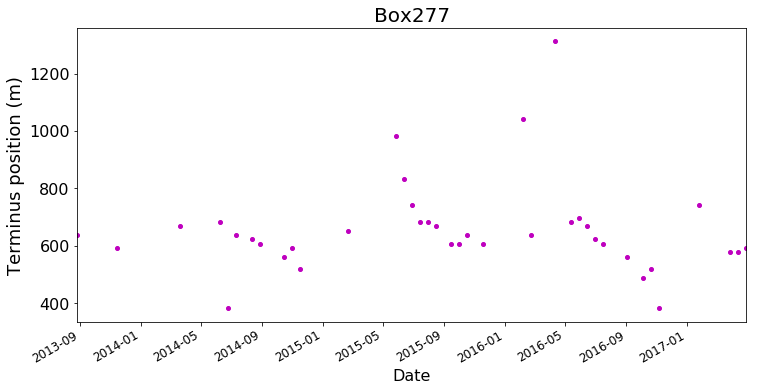

In [958]:
#PLOT TERMINUS POSITION 
ax = df_BOI_merged.plot(x='datetimes', y='term_position', color='m', marker='o', linestyle = 'None', figsize=(12,6), legend=None, markersize=4)
# firstpass.plot(x='datetimes', y='term_position', style='ko', ax=ax, legend=None, markersize=4)
# ax = firstpass.plot(x='datetimes', y='term_position', style='mo', figsize=(12,6), legend=None, markersize=4)
# df_BOI_s.plot(x='datetimes', y='xdist_midpoint', style='co-', ax=ax)
plt.ylabel('Terminus position (m)', fontsize=18)

# #PLOT TERMINUS CHANGE
# # drop any Nan values since they won't plot properly
# df_BOI_merged = df_BOI_merged.dropna()

# ax = df_BOI_merged.plot(x='datetimes', y='changerates', style='bo', figsize=(12,6), legend=None)
# plt.ylabel('Terminus change rate (m/d)', fontsize=18)

#PLOT PERCENT CLOUD
# df_BOI_m.Cloudpercent = df_BOI_m.Cloudpercent.astype(float)
# ax = df_BOI_m.plot(x='datetimes', y='Cloudpercent', style='co', figsize=(12,6), legend=None)
# plt.ylabel('% Cloud', fontsize=18)

#PLOT AVGPIXEL PERCENT
# df_BOI_m.Avgpixel_percent = df_BOI_m.Avgpixel_percent.astype(float)
# ax = df_BOI_m.plot(x='datetimes', y='Avgpixel_percent', style='ko', figsize=(12,6), legend=None)
# plt.ylabel('Avg pixel value (% of max)', fontsize=18)


#GENERAL PLOT PARAMETERS
plt.title("Box"+BOI, fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=16)
# plt.legend(labels=['Mass' ,'Size'])
# plt.legend(labels=['Mass'])

#SAVE FIGURE
# plt.savefig(basepath+"/Figures/Termposition_LS8_m_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Termchangerates_LS8_m_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Cloudpercent_LS8_m_Box"+BOI+".png", dpi=200)
# plt.savefig(basepath+"/Figures/Avgpixval_LS8_m_Box"+BOI+".png", dpi=200)

plt.show()

_Remnant code to plot terminus change values over the terminus position points:_

In [202]:
# #LABEL EACH POINT BY TERMINUS CHANGE RATE
# for i, changerate_m in enumerate(df_BOI_m.index):
# #     print(type(changerate), changerate)
#     #If the rate is a float (number or Nan), format it
#     if isinstance(changerate_m, float):
#         txt = str("{0:.2f}".format(changerate_m))
#         #If it's positive, add a + for clarity:
#         if changerate_m > 0:
#             txt = "+"+txt
#         #don't plot the nans
#         if np.isnan(changerate_m):
#             txt = " "
#     #for others, plot the string
#     else:
#         txt = str(changerate_m)
#     plt.annotate(txt, 
#                  xy=(list(df_BOI_m['datetimes'])[i] ,list(df_BOI_m['xdist_midpoint'])[i]), 
#                  fontsize=12,
#                  xytext=(6 ,4), 
#                  textcoords='offset points',
#                  color='m')
# for i, changerate_s in enumerate(df_BOI_s.index):
# #     print(type(changerate), changerate)
#     #If the rate is a float (number or Nan), format it
#     if isinstance(changerate_s, float):
#         txt = str("{0:.2f}".format(changerate_s))
#         #If it's positive, add a + for clarity:
#         if changerate_s > 0:
#             txt = "+"+txt
#         #don't plot the nans
#         if np.isnan(changerate_s):
#             txt = " "
#     #for others, plot the string
#     else:
#         txt = str(changerate_s)
#     plt.annotate(txt, 
#                  xy=(list(df_BOI_s['datetimes'])[i] ,list(df_BOI_s['xdist_midpoint'])[i]), 
#                  fontsize=12,
#                  xytext=(6 ,-10), 
#                  textcoords='offset points',
#                  color='c')

### Plot image and seglines

In [193]:
#add dat file x and ys in as dataframes:

#get list of images
print("Box"+BOI)
pathtoimgs = '/media/jukes/jukes1/LS8aws/Box'+BOI+'/rotated/resized/'
imgfiles = os.listdir(pathtoimgs)
images = []
term_dats = []
imgnames = []

for imgfile in imgfiles:
    #grab image files and append to images list
    if imgfile.endswith(BOI+".png"):
        print(imgfile)
        image = mpimg.imread(pathtoimgs+imgfile)
        
        #grab dat files
        pathtodat = pathtoimgs+imgfile[0:-4]+".pgm_max_gaussian/terminus_highestmass/"
        datfiles = os.listdir(pathtodat)
        
        #if there is a dat file:
        if len(datfiles) > 0:
            #grab the dat file and read it in and append to the list
            datfile = datfiles[0]
            print(datfile)
            term_dat = np.loadtxt(pathtodat+datfile)
            term_dats.append(term_dat)
            print(term_dat.shape)
            #append the image name
            images.append(image)
            imgnames.append(imgfile)
        else:
            print("NO DAT FILE FOUND")
            

print(len(term_dats), len(images))

Box001
crop_R_LC80340052015106LGN00_B8_PS_Buffer001.png
terminus_highestmass_016.dat
(50, 2)
crop_R_LC80340052015218LGN00_B8_PS_Buffer001.png
terminus_highestmass_013.dat
(59, 2)
crop_R_LC80340052015202LGN00_B8_PS_Buffer001.png
terminus_highestmass_019.dat
(79, 2)
crop_R_LC80340052013148LGN00_B8_PS_Buffer001.png
terminus_highestmass_007.dat
(59, 2)
crop_R_LC80340052017095LGN00_B8_PS_Buffer001.png
terminus_highestmass_008.dat
(119, 2)
crop_R_LC80340052014183LGN00_B8_PS_Buffer001.png
terminus_highestmass_017.dat
(27, 2)
crop_R_LC80340052015266LGN00_B8_PS_Buffer001.png
terminus_highestmass_014.dat
(74, 2)
crop_R_LC80340052016253LGN00_B8_PS_Buffer001.png
terminus_highestmass_049.dat
(43, 2)
crop_R_LC80340052015090LGN00_B8_PS_Buffer001.png
terminus_highestmass_032.dat
(55, 2)
crop_R_LC80340052014263LGN00_B8_PS_Buffer001.png
terminus_highestmass_048.dat
(41, 2)
crop_R_LC80340052015122LGN00_B8_PS_Buffer001.png
terminus_highestmass_048.dat
(41, 2)
crop_R_LC80340052016141LGN00_B8_PS_Buffer001.p

crop_R_LC80340052015202LGN00_B8_PS_Buffer001.png average pixel value: 0.28562254
crop_R_LC80340052017095LGN00_B8_PS_Buffer001.png average pixel value: 0.36437362
crop_R_LC80340052016125LGN00_B8_PS_Buffer001.png average pixel value: 0.21688671
crop_R_LC80340052016189LGN00_B8_PS_Buffer001.png average pixel value: 0.24517418
crop_R_LC80340052016205LGN00_B8_PS_Buffer001.png average pixel value: 0.25504142
crop_R_LC80340052016173LGN00_B8_PS_Buffer001.png average pixel value: 0.31532618
crop_R_LC80340052014247LGN00_B8_PS_Buffer001.png average pixel value: 0.3339636
crop_R_LC80340052015154LGN00_B8_PS_Buffer001.png average pixel value: 0.2765246
crop_R_LC80340052016157LGN00_B8_PS_Buffer001.png average pixel value: 0.27350658
crop_R_LC80340052016237LGN00_B8_PS_Buffer001.png average pixel value: 0.34981853
crop_R_LC80340052016221LGN00_B8_PS_Buffer001.png average pixel value: 0.26537254
Lines: 11


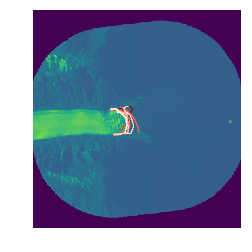

In [249]:
#imgplt = plt.imshow(images[40])
imgplt = plt.imshow(mpimg.imread('/home/jukes/Documents/Sample_glaciers/Box001/rotated_images/final/crop_PS_LC08_L1TP_031005_20180825_20180829_01_T1_B8_Buffer001cut.png'))
final_imgnames = []

xs = []
ys = []
for i in range(0, len(images)):
#     print(i)
    index = i
    #imgplt = plt.imshow(images[index])#cv2.cvtColor(images[2], cv2.COLOR_BGR2RGB))\
    avgpxval = np.average(images[index])
   
    #if the pixel value is above a threshold, then grab the terminus
    if avgpxval < 0.37:
        final_imgnames.append(imgnames[index])
        print(imgnames[index], "average pixel value:", avgpxval)
        term = term_dats[index]
        term_xs = []
        term_ys = []

        #grab x and y values for the terminus line
        for j in term:
            x, y = (j[0], j[1])
            term_xs.append(x)
            term_ys.append(y)
        
        xs.append(term_xs)
        ys.append(term_ys)

#create dataframe with the term line coordinates and sort by date
termlines_df = pd.DataFrame(
    {'imgnames': final_imgnames,
     'X': xs,
     'Y': ys
    })

termlines_df = termlines_df.sort_values(by=['imgnames'])
termlines_df.head()

# #create reversed red color map for the lines
n=len(termlines_df.index)
print("Lines:", n)
colors = pl.cm.Reds_r(np.linspace(0,1,n))
col_count = 0

name = list(termlines_df['imgnames'])
x_final = list(termlines_df['X'])
y_final = list(termlines_df['Y'])

#plot each termline
for a in range(0, n):
    x, y = x_final[a], y_final[a]
    pl.plot(x, y, color=colors[col_count], linewidth=1)
    col_count = col_count+1

plt.axis("off")
plt.savefig(basepath+"/Figures/AGU2019_autolines_Box"+BOI+".png", dpi=300)

_Remnant code on plotting teminus changes:_

In [435]:
# #PLOT:
# plt.figure(figsize=(12, 8))
# plt.plot(changerates.keys(), changerates.values(),'rx', markersize=15)

# #Label the points by the change rate (m/d)
# for i, changerate in enumerate(changerates.values()):
#     txt = "{0:.2f}".format(changerate)
#     plt.annotate(txt, xy=(list(changerates.keys())[i], list(changerates.values())[i]), fontsize=16)

# plt.title("Box"+BOI, fontsize=20)
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Terminus change (m/d)', fontsize=18)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=16)
# plt.gca().invert_yaxis()

# plt.show()

#### Explore pick quality:

In [580]:
# print(df_BOI_m.shape)
# df_BOI_m.head()

In [581]:
# #list of datetimes associated with potentially bad picks 
# flag_dt = []
# termpositions = []
# termchangerates = []

# for index, row in df_BOI_m.iterrows():
#     date = row['datetimes']
#     scene = row['Scene']
#     cloudpercent = float(row['Cloudpercent'])
#     avgpixval = float(row['Avgpixel_percent'])
#     termposition = row['xdist_midpoint']
#     termchange = row['changerates']
    
#     if avgpixval > 40.0:
#         flag_dt.append(date)
#         termpositions.append(termposition)
#         termchangerates.append(termchange)
#         print(date, "flagged")

In [583]:
# print(termpositions)
# print(len(termpositions))

In [582]:
# badpick_clouds = []
# badpick_avgpix = []
# badpick_dates = []

# for index, row in df_BOI_m.iterrows():
#     date = row['datetimes']
#     scene = row['Scene']
#     cloudpercent = float(row['Cloudpercent'])
#     avgpixval = float(row['Avgpixel_percent'])
#     termposition = row['xdist_midpoint']
#     termchange = row['changerates']
    
#     if termposition < 500.0 or termposition > 1300.0: # or termchange > 100.0:
#         badpick_dates.append(date)
#         badpick_clouds.append(cloudpercent)
#         badpick_avgpix.append(avgpixval)
#         print(date, "flagged")

In [584]:
# print(badpick_avgpix)
# print(len(badpick_avgpix))
# # print(badpick_clouds)